In [1]:
# JSMA (l0 norm-based)
import cv2
import numpy as np
import torch
from torchvision import models
from torch.autograd import Variable
from collections import abc as container_abcs


def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, container_abcs.Iterable):
        for elem in x:
            zero_gradients(elem)


# 对比展现原始图片和对抗样本图片
def show_images_diff(original_img, adversarial_img):
    import matplotlib.pyplot as plt
    plt.figure()

    # 归一化
    if original_img.any() > 1.0:
        original_img = original_img / 255.0
    if adversarial_img.any() > 1.0:
        adversarial_img = adversarial_img / 255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    # (-1,1)  -> (0,1)
    difference = difference / abs(difference).max() / 2.0 + 0.5
    plt.imshow(difference, cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# 获取计算设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载AlexNet分类模型
model = models.alexnet(pretrained=True).to(device).eval()
# 图像加载以及预处理
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
image_path = "cropped_panda.jpg"

original_img = cv2.imread(image_path)[..., ::-1]
original_img = cv2.resize(original_img, (224, 224))

img = original_img.copy().astype(np.float32)
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)
img = np.expand_dims(img, axis=0)
img = Variable(torch.from_numpy(img).to(device).float())

d:\ProgramData\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# 388 n02510455 熊猫, giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
output = model(img)
original_label = np.argmax(output.data.cpu().numpy())
original_label

388

In [3]:
# Saliency map
# 此方法为beta参数的简化版本，注重攻击目标贡献大的点
def saliency_map(F, x, t, mask):
    """
    :param F: 模型的输出
    :param x: 输入的图像
    :param t: 攻击的类别
    :param mask: 标记位，记录已经访问的点的坐标
    :return: Saliency map
    """
    F[0, t].backward(retain_graph=True)
    derivative = x.grad.data.cpu().numpy().copy()
    alphas = derivative * mask                  # 预测对攻击目标的贡献
    betas = -np.ones_like(alphas)               # 预测对非攻击目标的贡献
    sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
    idx = np.argmin(sal_map)                    # 最佳像素和扰动方向
    idx = np.unravel_index(idx, mask.shape)     # 转换成(p1,p2)格式
    pix_sign = np.sign(alphas)[idx]
    return idx, pix_sign

In [4]:
img.requires_grad = True
for param in model.parameters():
    param.requires_grad = False
epochs = 500
theta = 0.3                 # 扰动系数
target_label = 368          # 攻击目标
target = Variable(torch.Tensor([float(target_label)]).to(device).long())
loss_func = torch.nn.CrossEntropyLoss()

mask = np.ones_like(img.data.cpu().numpy())  # 定义搜索域，修改后的位置置零
# 定义边界
max_ = 3.0
min_ = -3.0

for epoch in range(epochs):
    output = model(img)
    label = np.argmax(output.data.cpu().numpy())
    loss = loss_func(output, target)
    print('epoch={} label={} loss={}'.format(epoch, label, loss))
    if label == target_label:
        break               # 攻击成功
    zero_gradients(img)     # 梯度清零
    idx, pix_sign = saliency_map(output, img, target_label, mask)
    # 添加扰动
    img.data[idx] = img.data[idx] + pix_sign * theta * (max_ - min_)
    # 达到极限的点不再参与更新
    if (img.data[idx] <= min_) or (img.data[idx] >= max_):
        print('idx={} over {}'.format(idx, img.data[idx]))
        mask[idx] = 0
        img.data.cpu()[idx] = np.clip(img.data.cpu()[idx], min_, max_)

epoch=0 label=388 loss=9.214811325073242
epoch=1 label=388 loss=9.166266441345215
epoch=2 label=388 loss=9.228776931762695
epoch=3 label=388 loss=9.179119110107422
epoch=4 label=388 loss=9.127028465270996
epoch=5 label=388 loss=9.034088134765625
epoch=6 label=388 loss=9.008891105651855
epoch=7 label=388 loss=8.983798027038574
epoch=8 label=388 loss=8.964847564697266
epoch=9 label=388 loss=8.952348709106445
epoch=10 label=388 loss=8.951905250549316
epoch=11 label=388 loss=8.900872230529785
epoch=12 label=388 loss=8.88648796081543
epoch=13 label=388 loss=8.825775146484375
epoch=14 label=388 loss=8.788663864135742
epoch=15 label=388 loss=8.77393627166748
epoch=16 label=388 loss=8.735697746276855
epoch=17 label=388 loss=8.826090812683105
epoch=18 label=388 loss=8.803011894226074
epoch=19 label=388 loss=8.824042320251465
epoch=20 label=388 loss=8.8712158203125
epoch=21 label=388 loss=8.830950736999512
epoch=22 label=388 loss=8.779717445373535
epoch=23 label=388 loss=8.799676895141602
epoch=

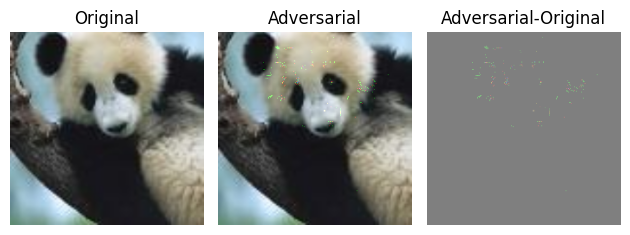

In [5]:
adversarial_img = img.data.cpu().numpy()[0]
adversarial_img = adversarial_img.transpose(1, 2, 0)
adversarial_img = (adversarial_img * std) + mean
adversarial_img *= 256.0
adversarial_img = np.clip(adversarial_img, 0, 255).astype(np.uint8)

show_images_diff(original_img, adversarial_img)

In [6]:
# 368 n02483362 猴子, gibbon, Hylobates lar
output = model(img)
new_label = np.argmax(output.data.cpu().numpy())
new_label

368